In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
path='/content/drive/MyDrive/Rohan/Denoising'
train_imgs = sorted(os.listdir(path + '/dataset/train'))
train_cleaned_imgs = sorted(os.listdir(path + '/dataset/train_cleaned'))
test_imgs = sorted(os.listdir(path + '/dataset/test'))

In [3]:
def process_image(path):
    # Reading image as float32 type
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    # Resize image to a fixed size 540 × 420
    img = cv2.resize(img, (540, 420))
    # Convert image to a gray one
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Normalize image to range 0-255
    img = img/255.0
    img = np.reshape(img, (420, 540, 3))
    
    return img

In [4]:
# preprocess images
train = []
train_cleaned = []
test = []

for i in train_imgs:
    train.append(process_image(path + '/dataset/train/' + i))

for i in train_cleaned_imgs:
    train_cleaned.append(process_image(path + '/dataset/train_cleaned/' + i))
   
for i in test_imgs:
    test.append(process_image(path + '/dataset/test/' + i))

In [5]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [6]:
def model():
    input_layer = Input(shape=(420, 540, 3))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [ ]:
#model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=400, batch_size=16)

Epoch 1/400


In [7]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=400, batch_size=16, callbacks=[callback])

Epoch 1/400
8/8 [==============================] - 43s 3s/step - loss: 0.1504 - mae: 0.3024 - val_loss: 0.1876 - val_mae: 0.4206
Epoch 2/400
8/8 [==============================] - 8s 1s/step - loss: 0.0747 - mae: 0.2062 - val_loss: 0.1424 - val_mae: 0.3660
Epoch 3/400
8/8 [==============================] - 8s 1s/step - loss: 0.0535 - mae: 0.1702 - val_loss: 0.1093 - val_mae: 0.3160
Epoch 4/400
8/8 [==============================] - 8s 1s/step - loss: 0.0419 - mae: 0.1444 - val_loss: 0.0826 - val_mae: 0.2624
Epoch 5/400
8/8 [==============================] - 9s 1s/step - loss: 0.0341 - mae: 0.1285 - val_loss: 0.0695 - val_mae: 0.2259
Epoch 6/400
8/8 [==============================] - 9s 1s/step - loss: 0.0284 - mae: 0.1149 - val_loss: 0.0642 - val_mae: 0.1980
Epoch 7/400
8/8 [==============================] - 9s 1s/step - loss: 0.0242 - mae: 0.1048 - val_loss: 0.0631 - val_mae: 0.1764
Epoch 8/400
8/8 [==============================] - 9s 1s/step - loss: 0.0210 - mae: 0.0962 - val_loss: 

In [ ]:
#model.save(path+'/model/my_model.h5')

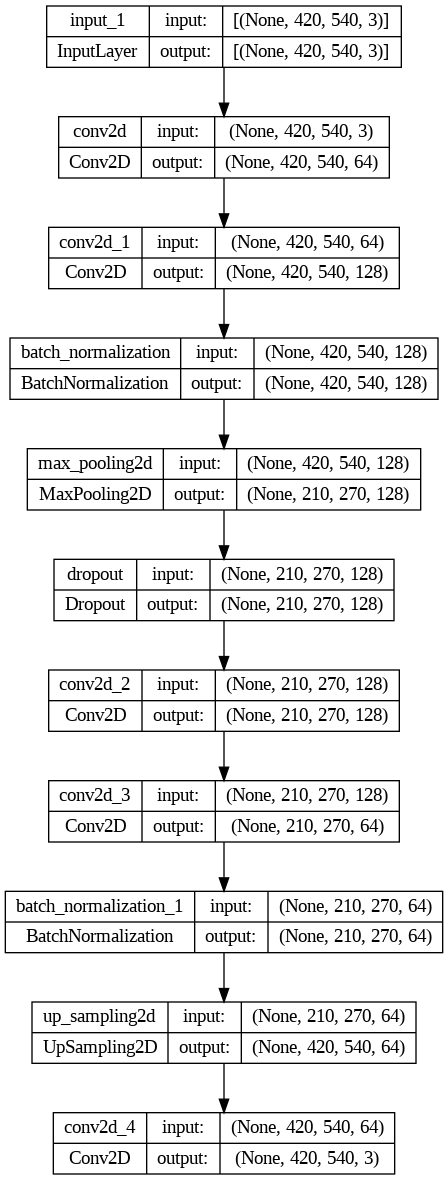

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [8]:
from keras.models import load_model
m = load_model(path+'/model/my_model.h5')

In [ ]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [ ]:
#Y_test = m.predict(X_test, batch_size=16)

In [ ]:
'''plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Noisy image: {}'.format(test_imgs[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_imgs[i]))

plt.show()'''

"plt.figure(figsize=(15,25))\nfor i in range(0,8,2):\n    plt.subplot(4,2,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.imshow(X_test[i], cmap='gray')\n    plt.title('Noisy image: {}'.format(test_imgs[i]))\n    \n    plt.subplot(4,2,i+2)\n    plt.xticks([])\n    plt.yticks([])\n    plt.imshow(Y_test[i], cmap='gray')\n    plt.title('Denoised by autoencoder: {}'.format(test_imgs[i]))\n\nplt.show()"

In [ ]:
img=[process_image('final.png')]
img=np.asarray(img)
#print(img)
a=m.predict(img)


1/1 [==============================] - 2s 2s/step


In [ ]:
#print(a)

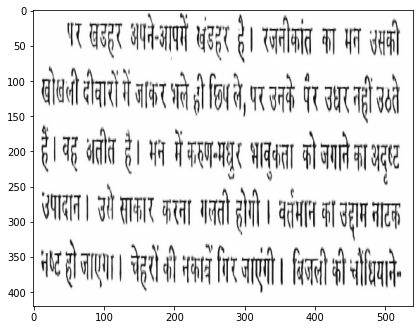

In [ ]:
plt.figure(figsize=(15,25))
plt.subplot(4,2,2)
plt.imshow(a[0], cmap='gray')
plt.show()

In [ ]:
#plt.savefig('save.jpg')
plt.imsave('save.jpg',a[0])

In [ ]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

In [ ]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [ ]:
dog = imread('images.jpeg')

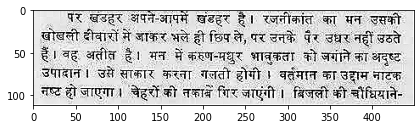

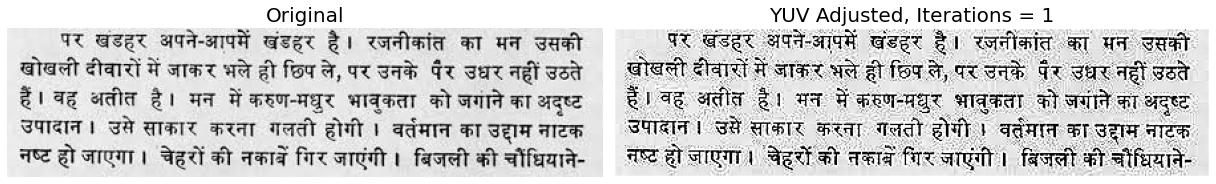

In [ ]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)   
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel, 
                                     iterations)
    final_image = yuv2rgb(img_yuv)
    plt.figure(figsize=(15,25))
    plt.subplot(4,2,2)
    plt.imshow(final_image, cmap='gray')
    plt.show()            
    plt.imsave('final.png',a[0])
    
    fig, ax = plt.subplots(1,2, figsize = (17,10))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Original', fontsize = 20)
    
    b=ax[1].imshow(final_image);
    b.get_figure().savefig('fig_name.png')
    ax[1].set_title(f'YUV Adjusted, Iterations = {iterations}', 
                    fontsize = 20)
    
    [axi.set_axis_off() for axi in ax.ravel()]
    
    fig.tight_layout()
    
    return final_image
final_image = convolver_rgb(dog, sharpen, iterations = 1)

In [ ]:
imshow(final_image)

AttributeError: ignored